In [1]:
# install
!pip install -q novosparc
!pip install -q altair

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os 
from matplotlib.pyplot import figure
import anndata
import novosparc
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import omnipath
%matplotlib inline

# Drosophila Dataset: Reconstruction and Visualiation 

In [3]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../data/raw_data/Drosophila/'
data_path = os.path.join(data_dir, 'matrix.csv')
dataset = sc.read(data_path,delimiter=",",first_column_names=True).T
#dataset = sc.read("/data/intercell_CellGATv2_Input/Drosophila/matrix.csv",delimiter=",",first_column_names=True)
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

number of cells: 1297
number of genes: 8924


/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# #preprocess
# sc.pp.normalize_per_cell(dataset)
# sc.pp.log1p(dataset)

In [5]:
atlas_dir = '../../data/raw_data/Drosophila/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

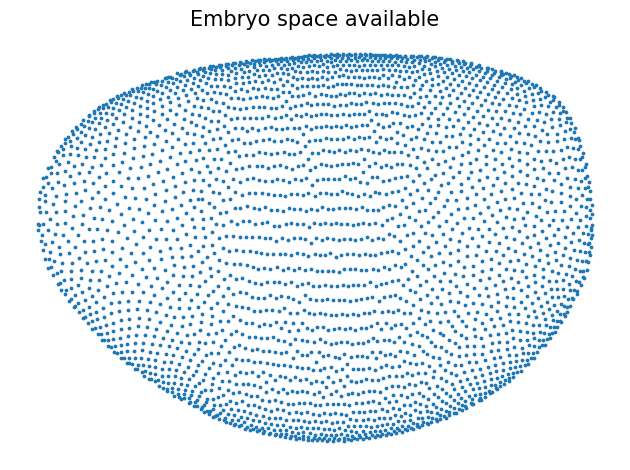

In [6]:
tit_size = 15
dpi = 100
#fig, ax = plt.subplots(1,1, figsize=(12,3), dpi=dpi)

plt.scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)
#ax[1].scatter(locations_from_image[:, 0], locations_from_image[:, 1], s=3)
#ax[2].scatter(locations_circle[:, 0], locations_circle[:, 1], s=3)

plt.title('Embryo space available', size=tit_size)
#ax[1].set_title('Prior shape without exact locations', size=tit_size)
#ax[2].set_title('No prior knowledge of target space', size=tit_size)

plt.axis('off')
#ax[1].axis('off')
#ax[2].axis('off')

plt.tight_layout()
plt.show()

# Reconstruct the tissue and visualize average gene expression

In [8]:
#dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# alternative 1: variable expressed genes representation
dge_rep = dataset.to_df()[var_genes]

# alternative 2: pca representation
#sc.pp.pca(dataset)
# dge_rep = pd.DataFrame(dataset.obsm['X_pca'])

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)
num_neighbors_s = num_neighbors_t = 5

# tissue.setup_reconstruction(num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# alternative: since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=dataset.var.index.tolist()))
dataset_reconst.obsm['spatial'] = locations_apriori

Setting up for reconstruction ... 

/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 2.69 seconds )
Reconstructing spatial information with 0 markers: 1297 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


/tmp/ipykernel_24660/1271521117.py:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=dataset.var.index.tolist()))
/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
results = pd.read_csv("../../data/CellGATv2_Output/Drosophila/CCI.csv",index_col=0)
#results = pd.merge(results,intercell,left_on=["Src","Dst"],right_on=["source","target"])
#results = results.head(1000)

In [10]:
resource = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv")

In [11]:
results[results["Src"].isin(resource["source"].tolist()) & results["Dst"].isin(resource["target"].tolist())]

,Src,Dst,Prob
4231,BSG,LAMP1,0.917838
18190,PCNA,LAMP1,0.917608
21151,CRP,LAMP1,0.916888
22420,ARPC5,LAMP1,0.914277
8038,HDC,LAMP1,0.914172
...,...,...,...
11125,FST,PDE1C,0.643360
37069,GAL,PDE1C,0.643350
39184,CUBN,PDE1C,0.643350
3229,TRH,PDE1C,0.643332


## top ranked interaction

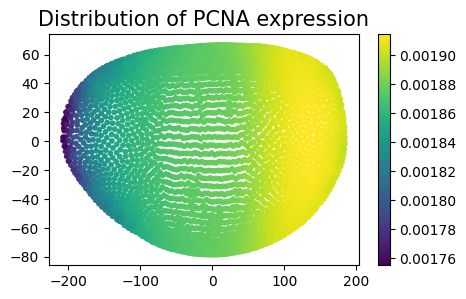

In [12]:
dataset = dataset_reconst
color = ["PCNA"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=tit_size)
    plt.colorbar(plot)
plt.show()

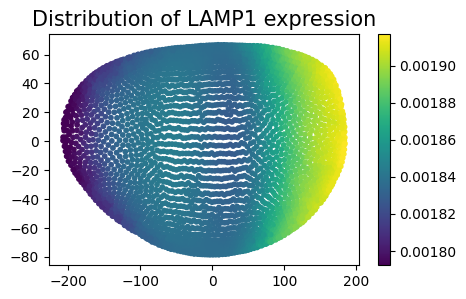

In [13]:
dataset = dataset_reconst
color = ["LAMP1"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=tit_size)
    plt.colorbar(plot)
plt.show()

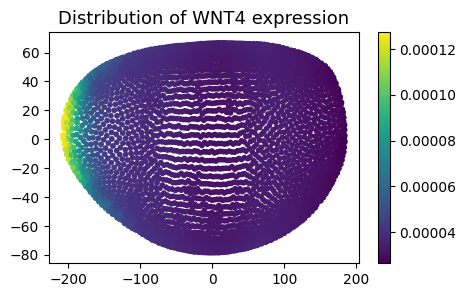

In [14]:
dataset = dataset_reconst
color = ["WNT4"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=13)
    plt.colorbar(plot)
#plt.tight_layout()
plt.show()

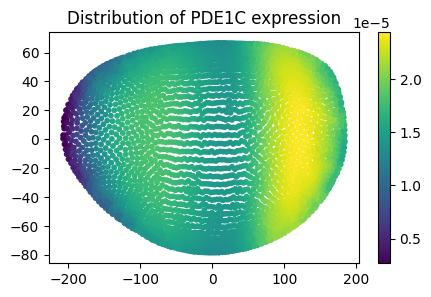

In [15]:
dataset = dataset_reconst
color = ["PDE1C"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=12)
    plt.colorbar(plot)
plt.show()

# Dataset 2: Mouse brain dataset (Figure 4)

In [16]:
intercell = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv")

In [17]:
consensus = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv")

In [18]:
mouse_intercell = intercell[intercell["references"].str.contains("Ramilowski")]

In [19]:
input_data=pd.read_csv("../../data/CellGATv2_Output/Mouse/CCI.csv")

In [20]:
truth = pd.read_csv("../../data/raw_data/Mouse/truth_interactions.csv")[["Ligand","Receptor"]]

In [21]:
truth["Ligand"] = [i.upper() for i in truth["Ligand"].tolist()]
truth["Receptor"] = [i.upper() for i in truth["Receptor"].tolist()]

In [22]:
intercell = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv")

In [26]:
input_data = input_data[input_data["Src"].isin(intercell["source"])]

In [27]:
input_data = input_data[input_data["Dst"].isin(intercell["target"])]

In [28]:
total_nodes = pd.read_csv("../../data/CellGATv2_Input/Mouse/nodes.csv")
consensus_nodes = pd.read_csv("../../data/CellGATv2_Input/consensus_Mouse/nodes.csv")

In [29]:
total_ligands = total_nodes[total_nodes["category"]=="Ligand"]["identifier"].unique().tolist()
total_receptors = total_nodes[total_nodes["category"]=="Receptor"]["identifier"].unique().tolist()
consensus_ligands = consensus_nodes[consensus_nodes["category"]=="Ligand"]["identifier"].unique().tolist()
consensus_receptors = consensus_nodes[consensus_nodes["category"]=="Receptor"]["identifier"].unique().tolist()

In [30]:
total_ligands = [i.split("_")[0] for i in total_ligands]
total_receptors = [i.split("_")[0] for i in total_receptors]
consensus_ligands = [i.split("_")[0] for i in consensus_ligands]
consensus_receptors = [i.split("_")[0] for i in consensus_receptors]

In [32]:
total_ligands = [i for i in total_ligands if i in intercell["source"].tolist()]
total_receptors = [i for i in total_receptors if i in intercell["target"].tolist()]

In [33]:
truth_total_ligands = [i for i in truth["Ligand"].unique().tolist() if i not in total_ligands]
truth_total_receptors = [i for i in truth["Receptor"].unique().tolist() if i not in total_receptors]
truth_consensus_ligands = [i for i in truth["Ligand"].unique().tolist() if i not in consensus_ligands]
truth_consensus_receptors = [i for i in truth["Receptor"].unique().tolist() if i not in consensus_receptors]

In [35]:
matrix = pd.read_csv("../../data/CellGATv2_Input/Mouse/matrix.csv",index_col=0)

In [36]:
ligands = [i for i in truth["Ligand"].unique().tolist() if i in matrix.index.tolist()]
receptors = [i for i in truth["Receptor"].unique().tolist() if i in matrix.index.tolist()]

In [37]:
intersect_total_ligands = list(set(ligands)&set(truth_total_ligands))
intersect_total_receptors = list(set(receptors)&set(truth_total_receptors))
intersect_consensus_ligands = list(set(ligands)&set(truth_consensus_ligands))
intersect_consensus_receptors = list(set(receptors)&set(truth_consensus_receptors))

In [38]:
len(intersect_total_receptors)

54

In [39]:
len(receptors)

179

In [41]:
random_list = []
for i in range(1,101):
    random_list.append(pd.read_csv(f"../../data/CellGATv2_random_data/Mouse/candidate_Mouse_{i}_random.csv",index_col=0))

In [42]:
random_list = [i.drop_duplicates() for i in random_list]

In [43]:
random_list = [i[["Src","Dst","Prob"]] for i in random_list]

In [44]:
random_list = [i.sort_values("Prob",ascending=False) for i in random_list]

In [45]:
new_random_list = []
for i in random_list:
    i.columns = ["Src","Dst","Prob"]
    new_random_list.append(i)

In [46]:
random_list = new_random_list

In [47]:
random_list = [i[["Src","Dst","Prob"]] for i in random_list]

In [49]:
random_list = [i[i["Src"].isin(intercell["source"])] for i in random_list]

In [50]:
random_list = [i[i["Dst"].isin(intercell["target"])] for i in random_list]

In [51]:
random_list = [i.head(100) for i in random_list]

In [52]:
total_random = pd.concat(random_list)

In [53]:
total_random.groupby("Dst").count().sort_values("Prob",ascending=False)

,Src,Prob
Dst,,
IL13RA1,166,166
ESRRA,138,138
CXADR,123,123
UNC5C,122,122
TYK2,107,107
...,...,...
LPP,7,7
HSPA8,7,7
THRA,7,7


In [54]:
random_dfs = random_list

In [55]:
important_ligands = truth["Ligand"].unique().tolist()
important_receptors = truth["Receptor"].unique().tolist()

In [56]:
CellGATv2_LR_list = []
for i in range(5,101,5):
    temp= input_data.head(i)
    ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
    receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
    CellGATv2_LR_list.append((np.sum(ligands)+np.sum(receptors))/(i*2))
random_LR_list = []
for i in random_dfs:
    sub_random = i
    sub_random_list = []
    for j in range(5,101,5):
        temp= sub_random.head(j)
        ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
        receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
        sub_random_list.append((np.sum(ligands)+np.sum(receptors))/(j*2))
    random_LR_list.append(sub_random_list)

In [57]:
mean_random_LR_list = list(np.mean(random_LR_list,axis=0))

In [58]:
CellGATv2_LR_list = [0] + CellGATv2_LR_list
mean_random_LR_list = [0] + mean_random_LR_list

Text(0, 0.5, 'Fraction of interactions containing relevant ligands/receptors')

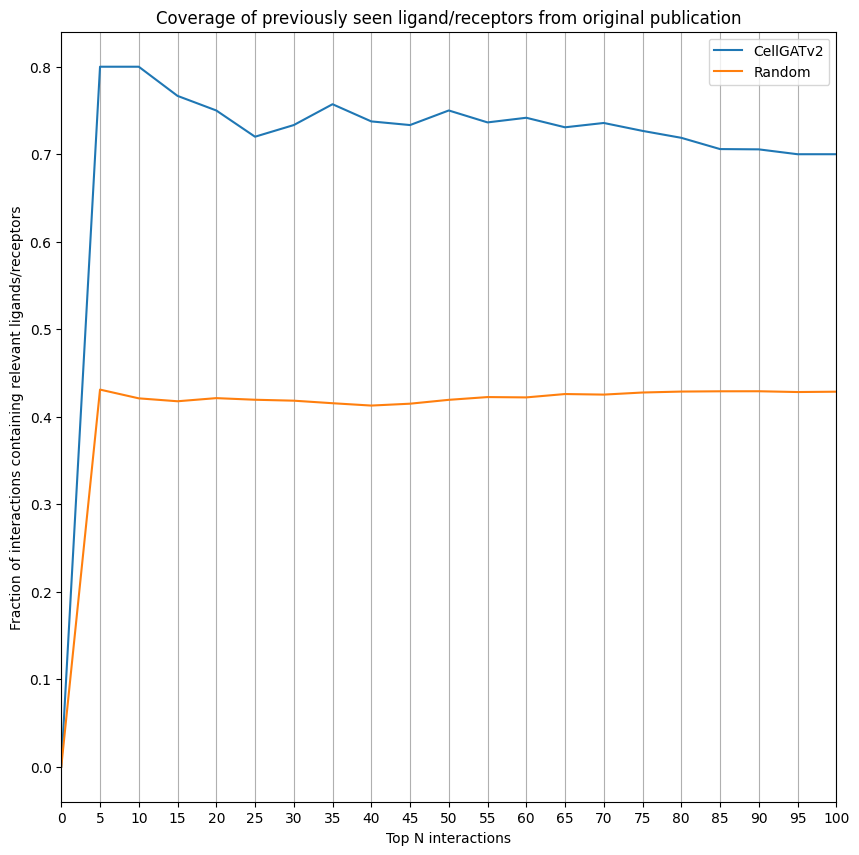

In [59]:
figure(figsize=(10,10))

plt.plot(range(0,101,5),CellGATv2_LR_list,label="CellGATv2")
plt.plot(range(0,101,5),mean_random_LR_list,label="Random")
plt.grid(axis = 'x')
plt.xticks(range(0,101,5))
plt.xlim((0,100))
#plt.ylim((0,10))
plt.legend()
plt.title("Coverage of previously seen ligand/receptors from original publication")
plt.xlabel("Top N interactions")
plt.ylabel("Fraction of interactions containing relevant ligands/receptors")
#plt.savefig("/results/cdf.png")

In [60]:
CellGATv2_LR_list

[0,
 0.8,
 0.8,
 0.7666666666666667,
 0.75,
 0.72,
 0.7333333333333333,
 0.7571428571428571,
 0.7375,
 0.7333333333333333,
 0.75,
 0.7363636363636363,
 0.7416666666666667,
 0.7307692307692307,
 0.7357142857142858,
 0.7266666666666667,
 0.71875,
 0.7058823529411765,
 0.7055555555555556,
 0.7,
 0.7]

# Dataset 3:scRNA PC9 cell line dataset with drug treatment - change comparison datasets to generate pre/post or biological replicate overlap (Figure 5)

### load datasets

In [117]:
day0=pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day0/CCI.csv",index_col=0)
day7_rep1=pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_1/CCI.csv",index_col=0)
day7_rep2=pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_2/CCI.csv",index_col=0)

In [118]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [119]:
Omnipath_database.columns = ["from","to","sources"]


### only retain, within each dataset, **validated intercell interactions from Omnipath**

In [120]:
day0=pd.merge(day0,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep1=pd.merge(day7_rep1,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep2=pd.merge(day7_rep2,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()

### find the number of common interactions within the top 100 between biological replicates (and save that value for the randomization experiment)

In [121]:
only_day7_1_ligands = day7_rep1[(~day7_rep1["Src"].isin(day0["Src"].tolist())) & (day7_rep1["Src"].isin(day7_rep2["Src"].tolist()))]
only_day7_1_receptors = day7_rep1[(~day7_rep1["Dst"].isin(day0["Dst"].tolist())) & (day7_rep1["Dst"].isin(day7_rep2["Dst"].tolist()))]

In [122]:
common = pd.merge(day7_rep1.head(150),day7_rep2.head(150))

In [123]:
original_accuracy = common.shape[0]/150

### use a stacked bar plot to visualize the commonalities

In [124]:
original_accuracy

0.8266666666666667

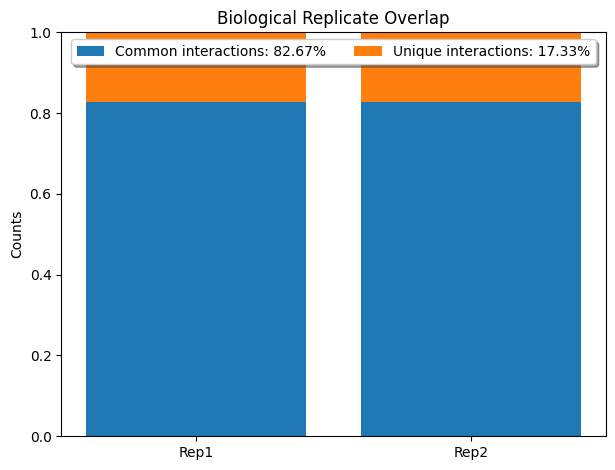

In [125]:
%matplotlib inline
labels = ["Rep1","Rep2"]
men_means = [round(common.shape[0]/150,3),round(common.shape[0]/150,3)]
women_means = [1- round(common.shape[0]/150,3),1- round(common.shape[0]/150,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(common.shape[0]/150*100,2)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(common.shape[0]/150*100,3),2)}%")

ax.set_ylabel("Counts")
ax.set_title("Biological Replicate Overlap")
ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


### find the number of common interactions within the top 100 between pre and post treatment datasets (and save that value for the randomization experiment)

In [126]:
pre_post_common = pd.merge(day0.head(150),day7_rep1.head(150))

In [127]:
pre_post_common.shape[0]/150

0.6266666666666667

### use a stacked bar plot to visualize the commonalities

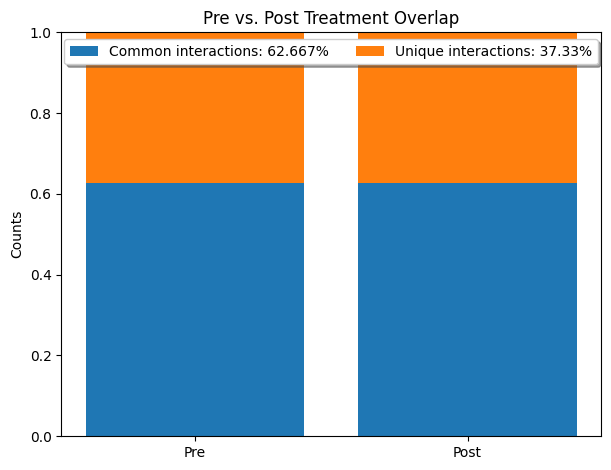

In [128]:
%matplotlib inline
labels = ["Pre","Post"]
men_means = [round(pre_post_common.shape[0]/150,3),round(pre_post_common.shape[0]/150,3)]
women_means = [1- round(pre_post_common.shape[0]/150,3),1- round(pre_post_common.shape[0]/150,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(pre_post_common.shape[0]/150*100,3)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(pre_post_common.shape[0]/150*100,3),2)}%")

ax.set_ylabel("Counts")
ax.set_title("Pre vs. Post Treatment Overlap")
ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


In [129]:
difference_accuracy = original_accuracy - pre_post_common.shape[0]/150

In [130]:
df = pd.merge(common, pre_post_common, on=['Src','Dst'], how='left', indicator='Exist')

## Compare difference between overlap biological replicates vs. pre and post for Original Set and 100 Randomized Interactions

### load the datasets

In [145]:
rep1_list = []
rep2_list = []
day_0_list = []
for i in range(0,100):
    day_0_list.append(pd.read_csv(f"../../data/CellGATv2_random_data/Pre_Post/Day0/Day0_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep1_list.append(pd.read_csv(f"../../data/CellGATv2_random_data/Pre_Post/Day7_1/Rep1_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep2_list.append(pd.read_csv(f"../../data/CellGATv2_random_data/Pre_Post/Day7_2/Rep2_{i+1}_random.csv",index_col=0)[["Src","Dst"]])

In [146]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)[["source","target"]].drop_duplicates()
Omnipath_database.columns = ["from","to"]

#### within each randomized Rep1 and Rep2, subset for validated intercell interactions

In [147]:
day_0_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in day_0_list]

In [148]:
rep1_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep1_list]

In [149]:
rep2_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep2_list]

In [150]:
day_0_list = [i[["Src","Dst"]] for i in day_0_list]
rep1_list = [i[["Src","Dst"]] for i in rep1_list]
rep2_list = [i[["Src","Dst"]] for i in rep2_list]

In [151]:
rep_merged_list = [pd.merge(i.head(150),j.head(150)) for i,j in zip(rep1_list,rep2_list)]

In [152]:
pre_post_merged_list = [pd.merge(i.head(150),j.head(150)) for i,j in zip(day_0_list,rep2_list)]

### find the difference in overlap between each biological replicates and pre and post treatment

In [153]:
difference_list = [abs((i.shape[0]/150) - (j.shape[0]/150)) for i,j in zip(rep_merged_list,pre_post_merged_list)]

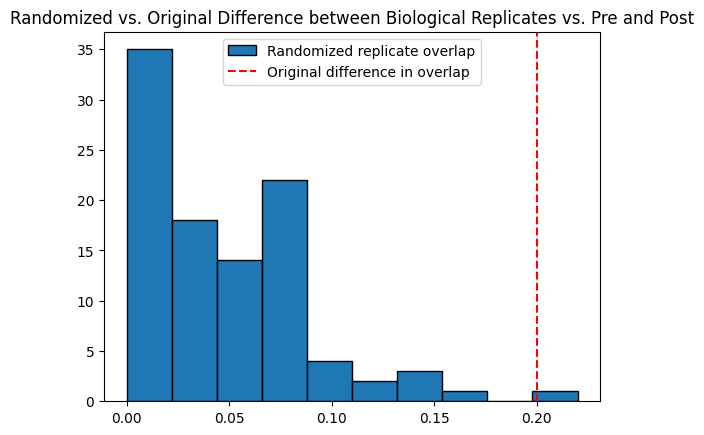

In [154]:
plt.hist(difference_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(difference_accuracy,linestyle="--",color="red",label="Original difference in overlap")
plt.title("Randomized vs. Original Difference between Biological Replicates vs. Pre and Post")
plt.legend()

## Compare overlap between biological replicates for Original Set and 100 Randomized Interactions

### find the fraction of overlap between each set of replicates

In [199]:
accuracy_list = [i.shape[0]/150 for i in rep_merged_list]

In [200]:
accuracy_list.index(min(accuracy_list))

28

In [201]:
pd.merge(rep1_list[4].head(150),rep2_list[4].head(150))

,Src,Dst
0,FYN,SYK
1,CLCF1,LIFR
2,BMP8B,BMPR1A
3,SEMA3D,NRP1
4,FYN,CSK
5,HLA-DMA,CTSS
6,BMP6,BMPR1A
7,VEGFB,NRP1
8,IL18,IL18R1
9,HLA-DRB1,LGMN


In [203]:
rep2_list[4].head(150)

,Src,Dst
0,VEGFA,ITGAV
1,VEGFA,NRP1
2,BMP2,BMPR1A
3,TNC,ITGAV
4,TYK2,IFNAR2
...,...,...
145,WNT11,LRP6
146,DKK1,KREMEN1
147,NRG4,ERBB2
148,DUSP18,ITGB8


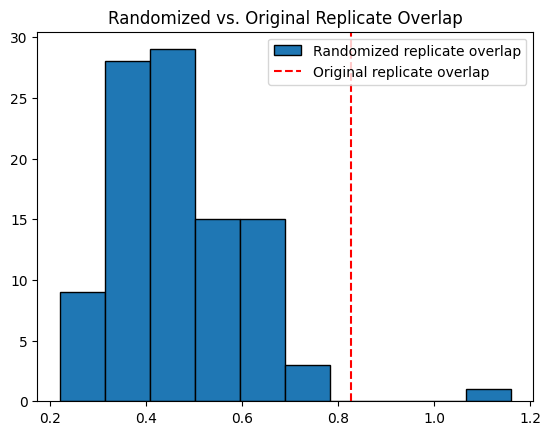

In [198]:
plt.hist(accuracy_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(original_accuracy,linestyle="--",color="red",label="Original replicate overlap")
plt.title("Randomized vs. Original Replicate Overlap")
plt.legend(loc="upper right")

# Dataset 5: Spatial Cardiovascular Data (Figure 6 & 7)

## Find most common interacting cell groups and spatial adjacency across all fibrotic and ischemic slides (Fig 4 B-G)

In [170]:
fibrotic_list = []
for i in os.listdir("../../data/CellGATv2_Output/Cardiac_cells/"):
    if "FZ" in i:
        temp_df = pd.read_csv(f"../../data/CellGATv2_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        fibrotic_list.append(temp_df)
fibrotic_CCI = pd.concat(fibrotic_list)

In [171]:
ischemic_list = []
for i in os.listdir("../../data/CellGATv2_Output/Cardiac_cells/"):
    if "IZ" in i:
        temp_df = pd.read_csv(f"../../data/CellGATv2_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        ischemic_list.append(temp_df)
ischemic_CCI = pd.concat(ischemic_list)

## remove self-loops

In [172]:
fibrotic_list = [i[i["Src Cell"] != i["Dst Cell"]] for i in fibrotic_list]
ischemic_list = [j[j["Src Cell"] != j["Dst Cell"]] for j in ischemic_list]

## from each slide, retain the top 100 interactions

In [173]:
fibrotic_CCI = pd.concat(fibrotic_list)
ischemic_CCI = pd.concat(ischemic_list)

In [174]:
fibrotic_CCI = pd.concat([i.head(100) for i in fibrotic_list])
ischemic_CCI = pd.concat([i.head(100) for i in ischemic_list])

In [175]:
fibrotic_CCI = fibrotic_CCI.sort_values("Prob",ascending=False)
ischemic_CCI = ischemic_CCI.sort_values("Prob",ascending=False)

In [176]:
fibrotic_cell_groups = list(set(fibrotic_CCI["Src Cell"].unique().tolist() + fibrotic_CCI["Dst Cell"].unique().tolist()))
ischemic_cell_groups = list(set(ischemic_CCI["Src Cell"].unique().tolist() + ischemic_CCI["Dst Cell"].unique().tolist()))

In [177]:
fibrotic_matrix = pd.DataFrame(index=fibrotic_cell_groups,columns=fibrotic_cell_groups)
ischemic_matrix = pd.DataFrame(index=ischemic_cell_groups,columns=ischemic_cell_groups)

In [178]:
fibrotic_CCI = fibrotic_CCI[["Src Cell","Dst Cell","Prob"]]
ischemic_CCI = ischemic_CCI[["Src Cell","Dst Cell","Prob"]]

In [179]:
fibrotic_CCI = fibrotic_CCI.groupby(["Src Cell","Dst Cell"]).count()
ischemic_CCI = ischemic_CCI.groupby(["Src Cell","Dst Cell"]).count()

In [180]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [181]:
for index,row in fibrotic_CCI.iterrows():
    fibrotic_matrix.loc[index[0],index[1]] += row["Prob"]
    fibrotic_matrix.loc[index[1],index[0]] += row["Prob"]

In [182]:
for index,row in ischemic_CCI.iterrows():
    ischemic_matrix.loc[index[0],index[1]] += row["Prob"]
    ischemic_matrix.loc[index[1],index[0]] += row["Prob"]

In [183]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [184]:
fibrotic_matrix

,Neuronal,vSMCs,Pericyte,Endothelial,Cycling.cells,Myeloid,Cardiomyocyte,Adipocyte,Mast,Fibroblast
Neuronal,0,2,88,1,0,1,2,0,0,0
vSMCs,2,0,6,20,28,0,62,12,2,8
Pericyte,88,6,0,9,8,4,9,3,30,0
Endothelial,1,20,9,0,12,1,9,0,11,1
Cycling.cells,0,28,8,12,0,6,62,31,74,0
Myeloid,1,0,4,1,6,0,1,5,34,0
Cardiomyocyte,2,62,9,9,62,1,0,49,7,2
Adipocyte,0,12,3,0,31,5,49,0,0,0
Mast,0,2,30,11,74,34,7,0,0,0
Fibroblast,0,8,0,1,0,0,2,0,0,0


In [185]:
import numpy as np

In [186]:
import seaborn as sns

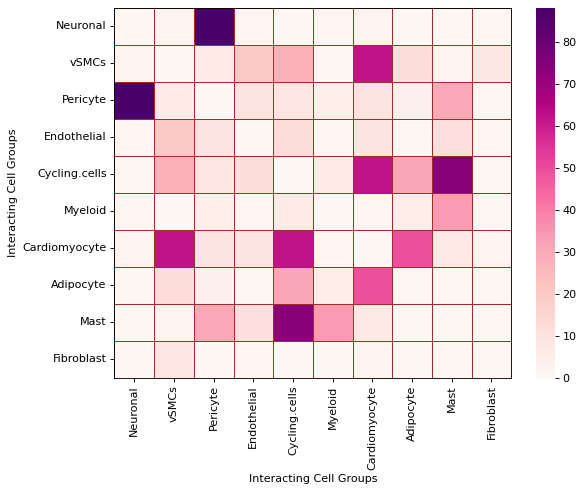

In [187]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(fibrotic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("Interacting Cell Groups")
ax.set_ylabel("Interacting Cell Groups")
for _, spine in ax.spines.items():
    spine.set_visible(True)

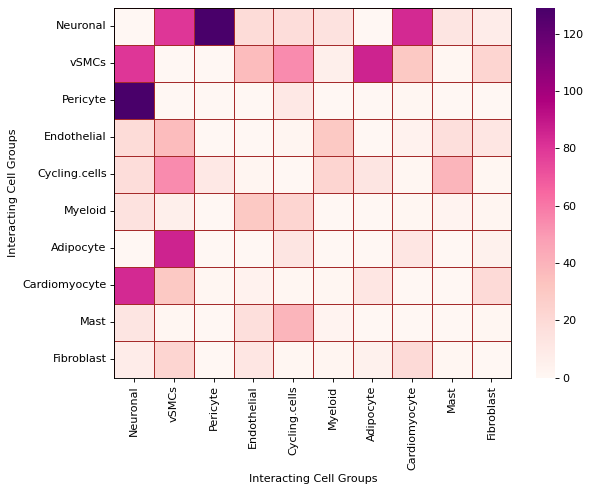

In [188]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(ischemic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("Interacting Cell Groups")
ax.set_ylabel("Interacting Cell Groups")
for _, spine in ax.spines.items():
    spine.set_visible(True)

# Comparison of spatial adjacency in a given fibrotic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [205]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [206]:
groups = ["vSMCs","Myeloid"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [207]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


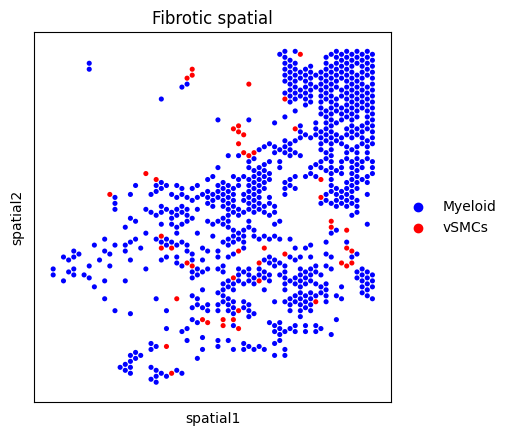

In [208]:
sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",palette=colour_dict,title="Fibrotic spatial")

In [209]:
import math

In [210]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [211]:
groups = ["Myeloid","vSMCs"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [212]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

/tmp/ipykernel_24660/237122405.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [213]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [214]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [215]:
total_list = []
data_list = []
one = "vSMCs"
two = "Myeloid"
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.min(min_list))


In [216]:
data_list

[0.017507574481738505]

## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [217]:
fibrotic_ints = pd.concat(fibrotic_list)

In [218]:
one="Myeloid"
two="vSMCs"

In [219]:
fibrotic_ints = fibrotic_ints[((fibrotic_ints["Src Cell"]==one)&(fibrotic_ints["Dst Cell"]==two)) | ((fibrotic_ints["Dst Cell"]==one)&(fibrotic_ints["Src Cell"]==two))]

In [221]:
consensus = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [223]:
fibrotic_ints = pd.merge(fibrotic_ints,consensus,left_on=["Src","Dst"],right_on=["source","target"])

In [224]:
fibrotic_ints.head()

,Src,Dst,Prob,Src Cell,Dst Cell,source,target,references
0,IGSF10,MILR1,0.882393,vSMCs,Myeloid,IGSF10,MILR1,Cellinker:32822567
1,LGALS9,HAVCR2,0.880433,vSMCs,Myeloid,LGALS9,HAVCR2,CellChatDB:27192565;CellTalkDB:27192565;Cellin...
2,TNFSF12,CD163,0.861380,vSMCs,Myeloid,TNFSF12,CD163,NetPath:17548657;connectomeDB2020:19473660
3,TNFSF12,CD163,0.512984,vSMCs,Myeloid,TNFSF12,CD163,NetPath:17548657;connectomeDB2020:19473660
4,HLA-DMB,CTSF,0.858290,Myeloid,vSMCs,HLA-DMB,CTSF,Macrophage:14966190


## Example visualization of scarce interaction

In [225]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_P14.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [226]:
groups = ["Cycling.cells","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [227]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


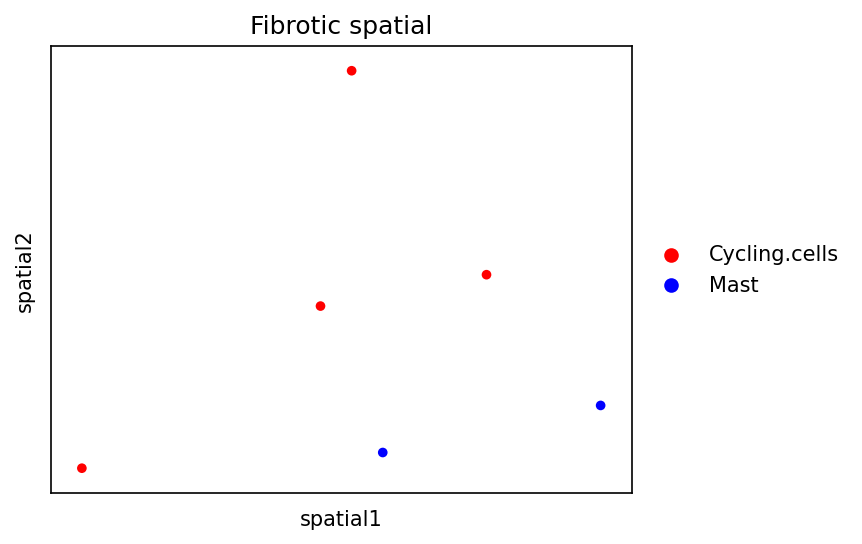

In [228]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

In [229]:
import math

In [230]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_P14.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [231]:
groups = ["Cycling.cells","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [232]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

/tmp/ipykernel_24660/237122405.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [233]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [234]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [235]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [236]:
data_list

[0.4408431381993679]

# Comparison of spatial adjacency in a given ischemic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [237]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_P3.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [238]:
groups = ["vSMCs","Endothelial"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [239]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]

/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


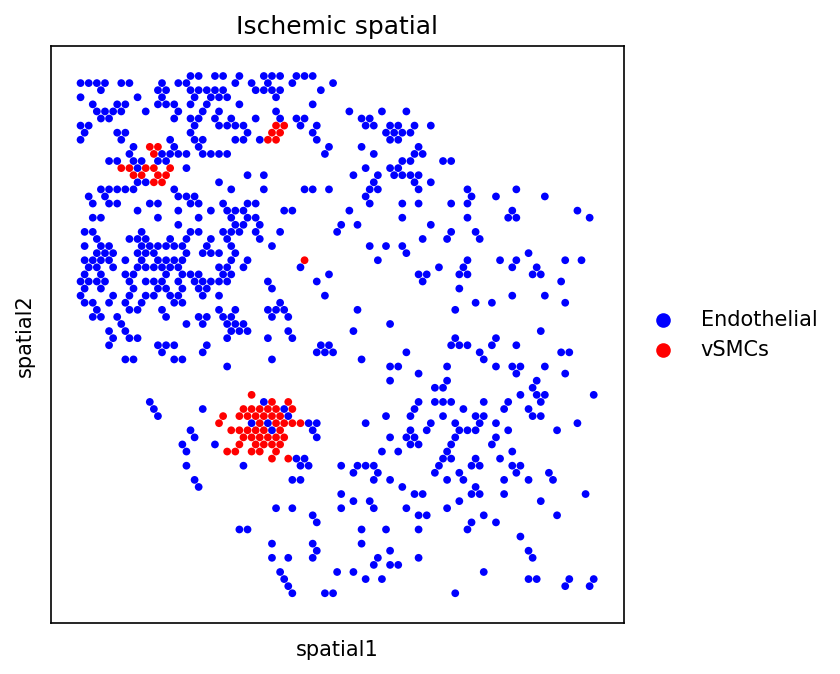

In [240]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",color_map="viridis",title="Ischemic spatial",palette=colour_dict)

In [241]:
import math

In [242]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_P3.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [243]:
groups = ["Endothelial","vSMCs"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [244]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

/tmp/ipykernel_24660/237122405.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [245]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [246]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [247]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.min(min_list))


In [248]:
min_list

[0.6086431322993181,
 0.42927332948597385,
 0.38697287985759743,
 0.3931251226164599,
 0.4826819878385391,
 0.49312050417655895,
 0.4859578289363444,
 0.5137650734968008,
 0.45088469946967946,
 0.6260742477162499,
 0.5356361609414092,
 0.3669836182622521,
 0.456673022761477,
 0.4315517155464037,
 0.3519476963718214,
 0.40979092873499534,
 0.4518771750578138,
 0.5299861201894301,
 0.6066510875373836,
 0.4999830707826499,
 0.5715416602230047,
 0.3928915975676247,
 0.5126415315707941,
 0.4605881397221527,
 0.3777878118064378,
 0.4727179713987133,
 0.43288932243144185,
 0.4216736153482668,
 0.422051219103171,
 0.424149605500127,
 0.39487273197020917,
 0.44434413990099364,
 0.4605553326798714,
 0.3595298482301705,
 0.419004918795767,
 0.4526427479959218,
 0.490630730869913,
 0.3604949143731585,
 0.47545484065782095,
 0.45095908061771045,
 0.3518763972727237,
 0.35325219032345945,
 0.3615172339947307,
 0.47212961318344826,
 0.7459256995920817,
 0.46898029327578605,
 0.5947065127773586,
 0.45

## Example visualization of scarce interaction

In [249]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_BZ_P2.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [250]:
groups = ["Adipocyte","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [251]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


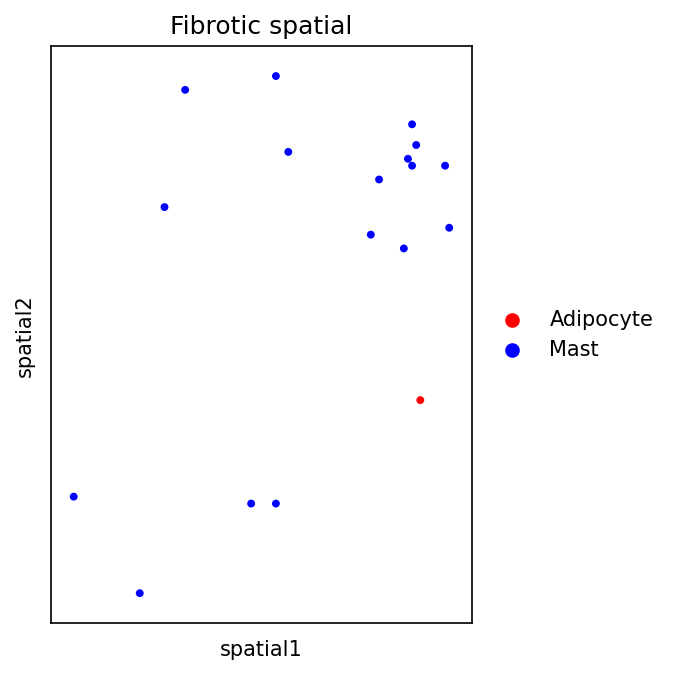

In [252]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

In [253]:
import math

In [254]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_BZ_P2.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [255]:
groups = ["Adipocyte","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [256]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

/tmp/ipykernel_24660/237122405.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [257]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [258]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [259]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.min(min_list))


In [260]:
data_list

[0.38889572269907635]

## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [261]:
ischemic_ints = pd.concat(ischemic_list)

In [262]:
one="vSMCs"
two="Endothelial"

In [263]:
ischemic_ints = ischemic_ints[((ischemic_ints["Src Cell"]==one)&(ischemic_ints["Dst Cell"]==two)) | ((ischemic_ints["Dst Cell"]==one)&(ischemic_ints["Src Cell"]==two))]

In [264]:
consensus = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [265]:
ischemic_ints = pd.merge(ischemic_ints,consensus,left_on=["Src","Dst"],right_on=["source","target"])

In [266]:
ischemic_ints.sort_values("Prob",ascending=False).head(10)

,Src,Dst,Prob,Src Cell,Dst Cell,source,target,references
20,FYN,PLD2,0.995573,Endothelial,vSMCs,FYN,PLD2,HPRD:12697812;KEA:15282299;KEA:9837959;SPIKE_L...
21,CXCL2,XCR1,0.964762,vSMCs,Endothelial,CXCL2,XCR1,Baccin2019:10518929;CellTalkDB:10679309;Cellin...
0,MMRN2,CD93,0.955698,vSMCs,Endothelial,MMRN2,CD93,connectomeDB2020:28671670
22,SIGLEC9,ADGRA2,0.954491,Endothelial,vSMCs,SIGLEC9,ADGRA2,Cellinker:32822567
23,S100A9,CD68,0.952720,vSMCs,Endothelial,S100A9,CD68,CellTalkDB:27312849
24,FYN,LPP,0.950153,Endothelial,vSMCs,FYN,LPP,KEA:17570479
25,SLIT3,ROBO4,0.949622,vSMCs,Endothelial,SLIT3,ROBO4,Cellinker:30288875;connectomeDB2020:19741192
28,SLIT3,ROBO1,0.949533,vSMCs,Endothelial,SLIT3,ROBO1,CellTalkDB:30288875;connectomeDB2020:19741192
29,SEMA3F,PLXNA3,0.948825,Endothelial,vSMCs,SEMA3F,PLXNA3,Baccin2019:15721238;CellTalkDB:15721238;HPMR:1...
30,PCNA,DNMT1,0.948648,Endothelial,vSMCs,PCNA,DNMT1,BioGRID:12354094;BioGRID:9302295;ELM:28073635;...


# Analysis of single slide *FZ_GT_P19*

### visualize the total spatial map of tissue

In [267]:
input_data = pd.read_csv("../../data/CellGATv2_Output/Cardiac_cells/FZ_GT_P19/CCI.csv",index_col=0)
input_data.index = range(0,input_data.shape[0])

In [268]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

### subset for **only validated intercell interactions**, and remove any self loops

In [269]:
#input_data = input_data[input_data["Src Cell"] != input_data["Dst Cell"]]
unique_groups = input_data.drop_duplicates(["Src Cell","Dst Cell"])

In [270]:
intercell_network = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [271]:
intercell_network.columns = ["source","target","refs"]

In [272]:
input_data[input_data["Src Cell"] == input_data["Dst Cell"]]

,Src,Dst,Prob,Src Cell,Dst Cell
0,TNFRSF10A,TRPC6,1.000000,vSMCs,vSMCs
2,FERMT1,ETV4,1.000000,vSMCs,vSMCs
3,IGSF1,ETV4,1.000000,vSMCs,vSMCs
6,ILDR2,TUBA3E,1.000000,Cardiomyocyte,Cardiomyocyte
7,CLSPN,TRPC6,1.000000,vSMCs,vSMCs
...,...,...,...,...,...
6840184,POU2AF1,MAJIN,0.126827,Mast,Mast
6840185,POU2AF1,DFFB,0.126827,Mast,Mast
6840186,POU2AF1,CHAF1B,0.126827,Mast,Mast
6840188,POU2AF1,ASGR2,0.000000,Mast,Mast


## generate table for Cytoscape network

### list top ranked or low ranked interactions

## identify patterns in cell group interactions in only validated LR pairs

In [273]:
top_input = input_data.head(1000)

In [274]:
top_input = top_input.groupby(["Src Cell","Dst Cell"]).sum("Prob")

In [275]:
top_input

Prob
Src Cell      Dst Cell                 
Cardiomyocyte Cardiomyocyte   76.333859
              Endothelial     19.298301
              Fibroblast       5.789806
              Myeloid         16.398657
              vSMCs          146.857368
Endothelial   Cardiomyocyte   38.641643
              Endothelial     11.578032
              Fibroblast       1.930462
              Myeloid          8.681549
              vSMCs           68.591465
Fibroblast    Cardiomyocyte    1.932043
              vSMCs            3.864085
Myeloid       Cardiomyocyte    7.718688
              vSMCs           14.472935
vSMCs         Cardiomyocyte  156.595811
              Endothelial     42.463848
              Fibroblast      11.582774
              Myeloid         30.871592
              vSMCs          302.511654

In [276]:
top_input = top_input.sort_values("Prob",ascending=False)

In [278]:
os.system("mkdir -p ../../results/CellGATv2_Output/Cardiac_cells/")

0

In [280]:
top_input.to_csv("../../results/CellGATv2_Output/Cardiac_cells/FZ_GT_P19_grouped.csv")

## Visualize top ranked interaction

In [281]:
input_data = pd.merge(input_data,intercell_network,left_on=["Src","Dst"],right_on=["source","target"])

In [282]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [283]:
groups = ["Myeloid","vSMCs"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [284]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

/tmp/ipykernel_24660/237122405.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


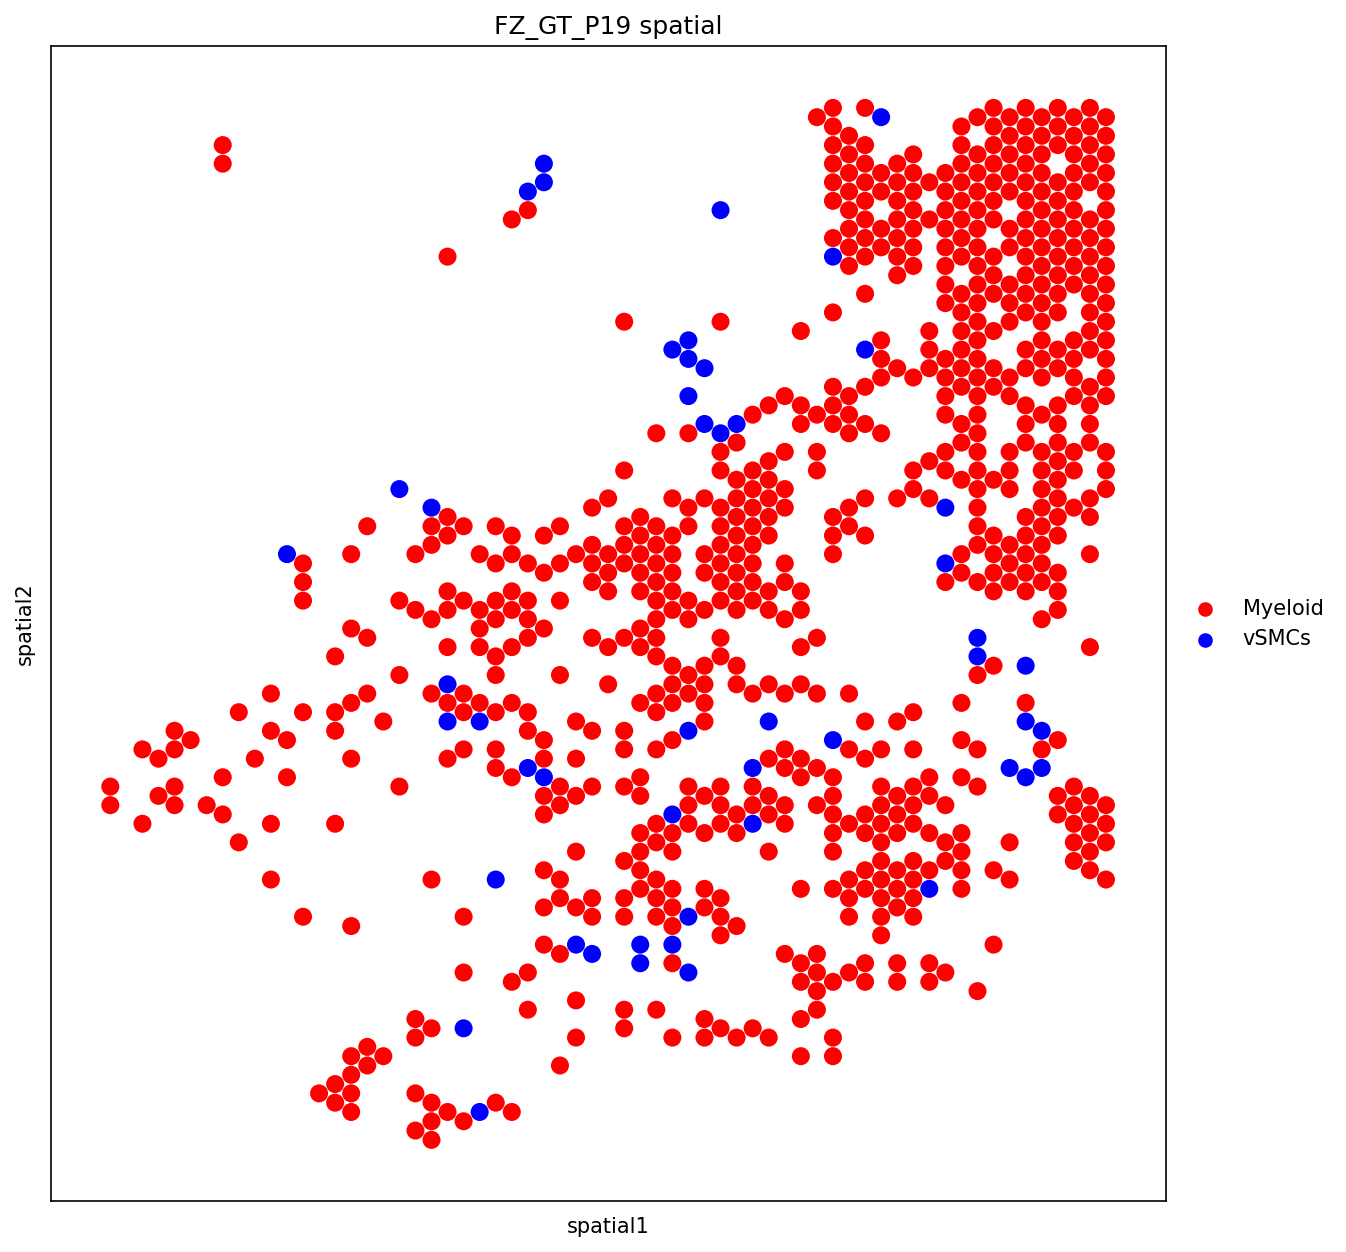

In [285]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (10, 10), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [286]:
new_meta = meta[(meta["labels"]=="vSMCs") | (meta["labels"]=="Myeloid")]

In [287]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [288]:
one="vSMCs"
two="Myeloid"

In [289]:
relevant_input = input_data[((input_data["Src Cell"]==one)&(input_data["Dst Cell"]==two)) | ((input_data["Dst Cell"]==one)&(input_data["Src Cell"]==two))]


In [290]:
relevant_input

,Src,Dst,Prob,Src Cell,Dst Cell,source,target,refs
2,CD52,SIGLEC10,0.926511,Myeloid,vSMCs,CD52,SIGLEC10,Cellinker:23685786;LRdb:23685786;connectomeDB2...
13,KITLG,LRRN3,0.925721,vSMCs,Myeloid,KITLG,LRRN3,Cellinker:32589946
19,ADCYAP1,DPP4,0.879099,vSMCs,Myeloid,ADCYAP1,DPP4,Cellinker:21314817
37,SIGLEC9,SIGLEC10,0.834848,Myeloid,vSMCs,SIGLEC9,SIGLEC10,Cellinker:32822567
44,GDNF,GFRA3,0.834848,Myeloid,vSMCs,GDNF,GFRA3,CellTalkDB:32196115
48,HP,CD163,0.833268,vSMCs,Myeloid,HP,CD163,CellTalkDB:25389409;HPRD:11854028;connectomeDB...
51,CXCL12,DPP4,0.829317,vSMCs,Myeloid,CXCL12,DPP4,CellTalkDB:30759373;Cellinker:11390394;HPRD:11...
101,HLA-B,SIGLEC10,0.785065,Myeloid,vSMCs,HLA-B,SIGLEC10,Cellinker:32822567
105,APOE,LSR,0.782695,Myeloid,vSMCs,APOE,LSR,Cellinker:7615497;ICELLNET:29178324
107,APOE,LRP8,0.781904,Myeloid,vSMCs,APOE,LRP8,AlzPathway:16504486;Baccin2019:12167620;Baccin...


## calculate mean eucledian distance between all spots of cell groups

In [291]:
import math

In [292]:
total_list = []
data_list = []
one = "vSMCs"
two = "Myeloid"
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [293]:
data_list

[0.4113401313944285]

## Visualize low-ranked interaction

In [294]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [295]:
groups = ["Cardiomyocyte","Endothelial"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [296]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

/tmp/ipykernel_24660/237122405.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


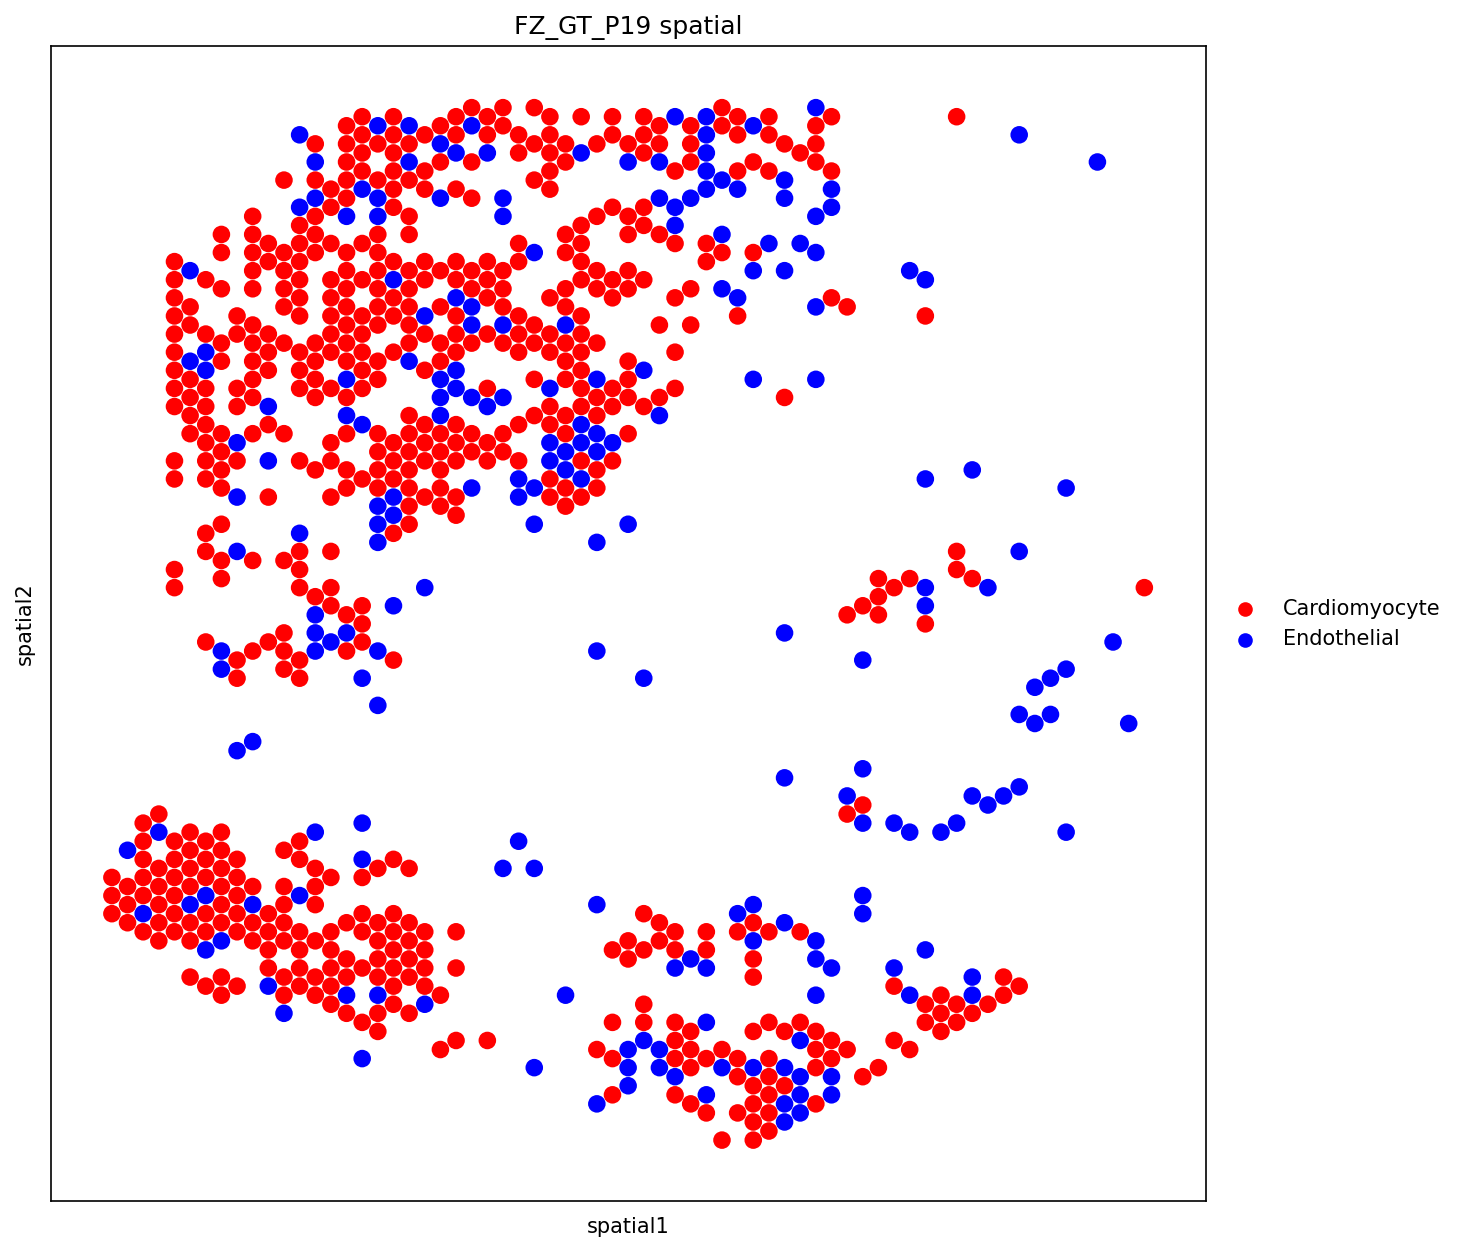

In [297]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (10, 10), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [298]:
one = "Cardiomyocyte"
two = "Endothelial"

In [299]:
new_meta = meta[(meta["labels"]==one) | (meta["labels"]==two)]

In [300]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [301]:
import math

In [302]:
total_list = []
data_list = []
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))
total_list.append(data_list)


In [411]:
data_list

[0.4800172957030988]

## Getting interactions from SCLC xenografts (Supplementary Tables)

In [28]:
pre_naive = pd.read_csv("/results/CellGATv2_Output/Pre_Post/GSE138267/GSM4104147_SC39.LB17019/CCI.csv")
pre_resistant = pd.read_csv("/results/CellGATv2_Output/Pre_Post/GSE138267/GSM4104163_SC55.LB19001/CCI.csv")
post_naive = pd.read_csv("/results/CellGATv2_Output/Pre_Post/GSE138267/GSM4104164_SC68_cr.LB19003/CCI.csv")
post_resistant = pd.read_csv("/results/CellGATv2_Output/Pre_Post/GSE138267/GSM4104156_SC55-2.LB17002/CCI.csv")

In [29]:
intercell = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)
intercell.columns = ["from","to","sources"]

In [30]:
pre_naive = pre_naive[pre_naive["Src"].isin(intercell["from"].tolist()) & pre_naive["Dst"].isin(intercell["to"].tolist())]
pre_resistant = pre_resistant[pre_resistant["Src"].isin(intercell["from"].tolist()) & pre_resistant["Dst"].isin(intercell["to"].tolist())]
post_naive = post_naive[post_naive["Src"].isin(intercell["from"].tolist()) & post_naive["Dst"].isin(intercell["to"].tolist())]
post_resistant = post_resistant[post_resistant["Src"].isin(intercell["from"].tolist()) & post_resistant["Dst"].isin(intercell["to"].tolist())]

In [31]:
pre_naive.head(500).to_csv("/results/pre_naive.csv")
pre_resistant.head(500).to_csv("/results/pre_resistant.csv")
post_naive.head(500).to_csv("/results/post_naive.csv")
post_resistant.head(500).to_csv("/results/post_resistant.csv")

In [32]:
post_resistant.head(50)

,Unnamed: 0,Src,Dst,Prob
155,132914,ACTR2,APP,0.743129
157,161968,HLA-DMB,APP,0.743120
158,159580,ICAM3,APP,0.743119
192,77194,KMT2E,APP,0.742757
399,157590,OXT,APP,0.627564
442,165152,GRN,APP,0.627230
554,98686,TP53,APP,0.609509
674,145252,HSPA8,APP,0.602638
1714,133710,VEGFB,APP,0.588962
1718,39782,IL32,APP,0.588919


In [ ]:
categories = omnipath.interactions.ct